# Fully Connected Network


## Network Architecture


In previous lessons ([lesson 2](../02_RéseauFullyConnected/README.md)), we built fully connected neural networks for classification problems. Here, we address a prediction problem with discrete data.


### Model Inspiration


The network presented in this notebook is inspired by the article ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).
Here is the architecture of this network:
![Bengio](./images/bengio.png)
Figure extracted from the original article.


In the article, the model uses three words as input to predict the next word. In our case, we will use characters, as in the previous notebook.
**Embedding matrix $C$**: We observe that the network contains a matrix $C$ that encodes words (or characters) into a latent space. This practice is common in NLP as it brings similar words closer together in this space. For example, in most sentences, you can interchange "dog" and "cat", which means these words will have a close representation in the latent space, unlike "dog" and "is".
**Rest of the network**: The rest of the network is more classical. It takes as input the concatenation of the embeddings of the different words (or characters) and predicts a word (or character) as output.


The model in the article is trained by minimizing the *negative log-likelihood* (as we did in the previous notebook with the bigram model).


### Our Approach


In the article, they use three words to predict the fourth word. We will apply the same principle and predict the fourth character from the three previous characters.
The dimension of the latent space used in the article is 30 for a dictionary containing 17,000 distinct words. Since we have 46 characters, we will arbitrarily choose an embedding dimension of 10.


## Network Implementation


Let's start by rebuilding our stoi and itos lists from the [previous notebook](../05_NLP/02_bigramme.ipynb):


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
%matplotlib inline

In [2]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Creating the Dataset and Dataloader


Let's build our dataset, which differs slightly as the inputs will be three instead of one.


In [3]:
block_size = 3 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    if (k<2): ## On affiche ce à quoi ressemble le dataset pour les deux premiers mots
      print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

... ---> M
..M ---> A
.MA ---> R
MAR ---> I
ARI ---> E
RIE ---> .
... ---> J
..J ---> E
.JE ---> A
JEA ---> N
EAN ---> .


In [4]:
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([226325, 3]) torch.int64 torch.Size([226325]) torch.int64


We will now use PyTorch to build our training, validation, and test datasets.


In [5]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
print("Taille du dataset de training : ",len(train_dataset))
print("Taille du dataset de validation : ",len(val_dataset))
print("Taille du dataset de test : ",len(test_dataset))

Taille du dataset de training :  181060
Taille du dataset de validation :  22632
Taille du dataset de test :  22633


We will also create our dataloaders for mini-batch optimization.


In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Network Layers


To better understand the network we are building, we will not use PyTorch's nn.Linear() functions to create the layers.
We will first define the number of neurons for each layer.


In [7]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

Let's build our embedding matrix $C$ (with learnable parameters).


In [8]:
C = torch.randn((46, embed_dim))
C[X].shape

torch.Size([226325, 3, 10])

By calling C[X], thanks to PyTorch indexing ([link](http://blog.ezyang.com/2019/05/pytorch-internals/)), we get the embedding values of each of the three characters in our 226,325 examples.


We can now create our hidden layers $W_1$ and $W_2$ as well as their biases $b_1$ and $b_2$.


In [9]:
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
print("Nombre de paramètres du modèle : ",sum(p.nelement() for p in parameters))

Nombre de paramètres du modèle :  15906


To train these layers, we need to enable the *requires_grad* parameter in PyTorch. This allows us to specify that we want to calculate gradients for these elements.


In [10]:
for p in parameters:
  p.requires_grad = True

### How to Choose the Right Learning Rate?


Choosing the learning rate is crucial when training a neural network and it is often difficult to determine the right value without prior testing.
A good method to choose the learning rate is:
- Create a list of 1000 values between -3 and 0
- Take $10^{value}$ for each value
This gives us a list of values between $10^{-3} = 0.001$ and $10^{0} = 1$, which are potential candidates for the learning rate. The values -3 and 0 can vary; you need to try to find values that bracket the optimal learning rate.


In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

Next, we will track the loss values as a function of the learning rate for the set of training values.


In [12]:
lri = []
lossi = []
count=0
while count<999:
  for x,y in train_loader:
    count+=1
    if count==999:
        break
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr = lrs[count]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lre[count])
    lossi.append(loss.log10().item())

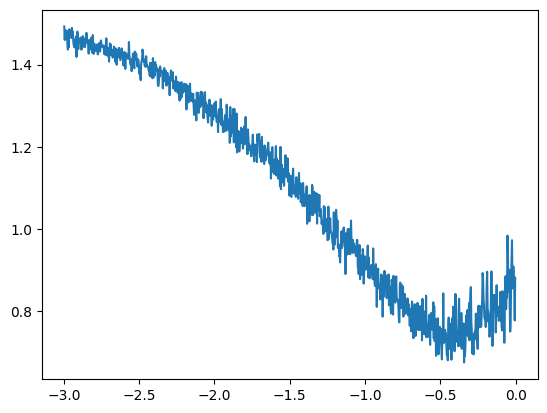

In [13]:
plt.plot(lri, lossi)

This curve shows that a good learning rate value is between $10^{-1}$ and $10^{-0.5}$.
We will therefore choose a learning rate of 0.2, which we will decrease during training (a common practice for fast convergence and precise optimization at the end of training).


### The Hyperbolic Tangent Function


In our optimization, we used the hyperbolic tangent function as the activation function.
It is defined as follows:
$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
You can visualize it in Python:


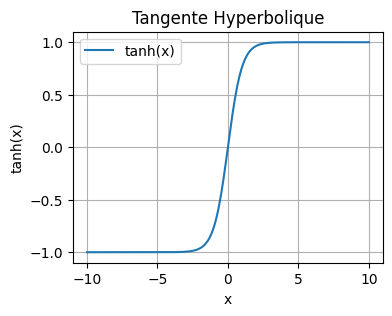

In [14]:
import numpy as np
x = np.linspace(-10, 10, 400)

y = np.tanh(x)

plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)')
plt.title('Tangente Hyperbolique')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.show()

Generally, in the hidden layers of our network, we prefer to use the *tanh* function over the *sigmoid* function for several reasons:
- The output range centered on zero (-1 to 1) facilitates learning.
- The gradients are more significant for values between -2 and 2 than for the sigmoid function.
- These two points contribute to reducing the problem of [vanishing gradient](https://medium.com/@amanatulla1606/vanishing-gradient-problem-in-deep-learning-understanding-intuition-and-solutions-da90ef4ecb54) and allow for faster convergence during training.


### Network Optimization


Now let's move on to optimizing our network. Let's define our hyperparameters:


In [15]:
lr=0.2
epochs=100

# Reinitialisons les paramètres pour plus de simplicité si on a besoin de relancer l'entraînement
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True


In [16]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss

  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  # Calcul du loss de validation (pour surveiller l'overfitting)
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 5.273, Validation loss: 3.519
Epoch 10 - Training loss: 2.424, Validation loss: 2.594
Epoch 20 - Training loss: 2.337, Validation loss: 2.421
Epoch 30 - Training loss: 2.289, Validation loss: 2.468
Epoch 40 - Training loss: 2.259, Validation loss: 2.424
Epoch 50 - Training loss: 2.327, Validation loss: 2.372
Epoch 60 - Training loss: 2.326, Validation loss: 2.372
Epoch 70 - Training loss: 2.326, Validation loss: 2.372
Epoch 80 - Training loss: 2.326, Validation loss: 2.372
Epoch 90 - Training loss: 2.326, Validation loss: 2.372


Let's plot the training and validation curves.


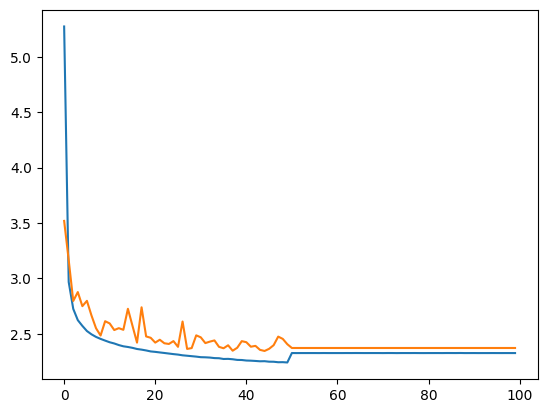

In [17]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

### Model Testing


Now that the model is trained, we will check its performance on the test data. If the loss on the test data is similar to that of the training, then the model is well trained. Otherwise, there may be overfitting (*overfitting*).


In [18]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
for p in parameters:
  p.requires_grad = False
loss_test=0
for x,y in test_loader:
      
  # forward pass
  emb = C[x]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, y)

  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.3505)


The likelihood on the test data is relatively close to that of the training data, which shows that the training went well.


We observe that the *negative log-likelihood* value of our model is lower than that of the bigram model from the previous notebook ($2.3 < 2.5$). The quality of the generated names should therefore be improved.


### Generating Names with Our Model


Let's generate about twenty names to evaluate the quality of the generation ourselves.


In [19]:
for _ in range(20):
  out = []
  context = [0] * block_size 
  while True:
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

JAÏMANT.
SONELIUWAN.
LYPHELSÏL.
DJELINATHEYMONDALYANE.
ERNANDRAN.
ESMALLOONIS.
ASHAMLANCHOND.
ANNAE.
CHALLA.
ETTE.
ASSANE.
MARIANE.
FIHAYLAY.
SHANA.
ALPHENELIESON.
ESÏL.
EVEY.
YSLALLYSSIA.
ETHELDOF.
KELLAH.


The generated names are still strange, but they already look much more like "possible" names compared to those produced by the bigram model.


**Exercise**: Try modifying the number of neurons in the layers or the hyperparameters to improve the model and observe the difference in generation quality.


## Visualizing Embeddings


Earlier in the notebook, we explained the intuition behind the *embedding* matrix $C$, which brings words (or characters) with a close meaning closer together. It is not easy to visualize the position of each character in the matrix $C$. To achieve this, we will retrain a model with an *embedding* dimension of 2 instead of 10. This will allow us to visualize the matrix $C$.
**Note**: To visualize embeddings with a dimension greater than 2 in 2D, you can use the [T-SNE or UMAP](https://arize.com/blog-course/reduction-of-dimensionality-top-techniques/) method.


In [23]:
lr=0.2
epochs=100

C = torch.randn((46, 2)) # 2 au lieu de embed_dim
W1 = torch.randn((block_size*2, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [24]:
lossi=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 3.822, Validation loss: 3.294
Epoch 10 - Training loss: 2.490, Validation loss: 2.616
Epoch 20 - Training loss: 2.425, Validation loss: 2.532
Epoch 30 - Training loss: 2.388, Validation loss: 2.498
Epoch 40 - Training loss: 2.365, Validation loss: 2.529
Epoch 50 - Training loss: 2.386, Validation loss: 2.399
Epoch 60 - Training loss: 2.385, Validation loss: 2.399
Epoch 70 - Training loss: 2.386, Validation loss: 2.399
Epoch 80 - Training loss: 2.385, Validation loss: 2.399
Epoch 90 - Training loss: 2.385, Validation loss: 2.399


As you can see, the loss is higher because an *embedding* dimension of 2 is insufficient to properly represent each character.
On the other hand, we can now visualize the position of the characters in the latent space.


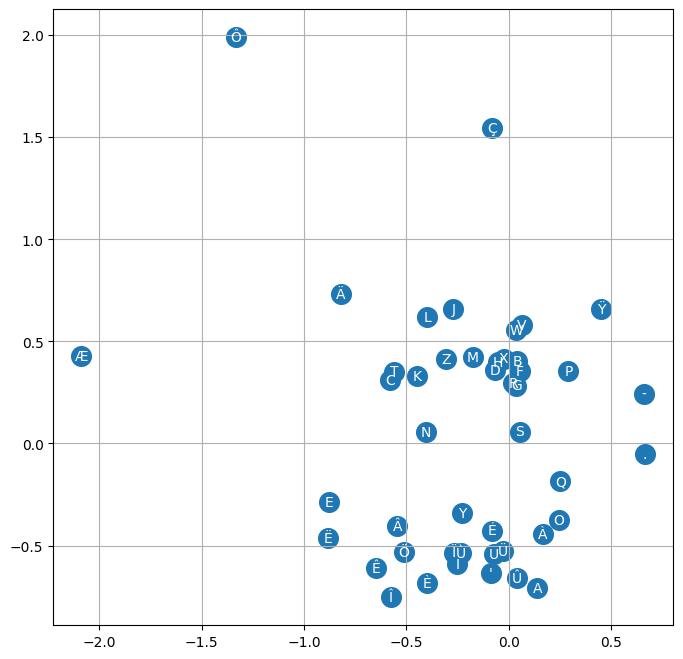

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

We observe a trend with clustering of vowels and consonants (often interchangeable in a name). Rare characters have distinct embeddings ('ç', 'ö', 'ë'). We also notice the proximity between '.' and '-' which is logical for a compound French name.
This shows that the matrix $C$ has learned a kind of *mapping* of characters based on their semantic proximity.
